In [31]:
import re
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

In [33]:
def convert(text):
  patterns = {
  '[àáảãạăắằẵặẳâầấậẫẩ]': 'a',
  '[đ]': 'd',
  '[èéẻẽẹêềếểễệ]': 'e',
  '[ìíỉĩị]': 'i',
  '[òóỏõọôồốổỗộơờớởỡợ]': 'o',
  '[ùúủũụưừứửữự]': 'u',
  '[ỳýỷỹỵ]': 'y'
  }
  output = text
  for regex, replace in patterns.items():
    output = re.sub(regex, replace, output)
    # deal with upper case
    output = re.sub(regex.upper(), replace.upper(), output)
  return output.lower()

class Compute_TF_IDF():
  def __init__(self, list_document, dictionary=None, max_count=None, min_count=10, normalize_tf=False, smooth=True, normalize_tfidf=None):
    self.list_document = list_document
    self.max_count = max_count
    self.min_count = min_count
    self.normalize_tf = normalize_tf
    self.smooth = smooth
    self.normalize_tfidf = normalize_tfidf

    self.dictionary = dictionary if dictionary != None else self.create_dictionary()
    self.word_to_index = self.mapping_word_to_index()
    self.num_word = len(self.dictionary)
    self.num_document = len(self.list_document)
    self.matrix_word_count = self.create_count_matrix()
    self.idf_score = self.compute_idf()
  
  # Query word given index based on dictionary
  def retrieve_word(self, index):
    if 0 <= index <= self.num_word - 1:
      return self.dictionary[index]
    else:
      return -1
  
  # Query index given word based on dictionary
  def retrieve_index(self, word):
    return self.word_to_index.get(word.lower(), -1)

  # Split document into list of words
  def word_extraction(self, document):
    split_word = document.split()
    return split_word

  def map_word_to_count(self):
    dict_word_count = dict()
    for i in range(len(self.list_document)):
      list_word = self.word_extraction(self.list_document[i].lower())
      for j in range(len(list_word)):
        dict_word_count[list_word[j]] = dict_word_count.get(list_word[j], 0) + 1
    return dict_word_count

  def create_dictionary(self):
    if self.max_count == None and self.min_count == None:
      set_word = set()
      for document in self.list_document:
        set_word = set_word.union(set(self.word_extraction(document.lower())))
    else:
      set_word = set()
      mapping_word_count = self.map_word_to_count()
      for document in self.list_document:
        list_word = self.word_extraction(document.lower())
        for word in list_word:
          if self.min_count != None:
            if mapping_word_count[word] < self.min_count:
              continue
          if self.max_count != None:
            if mapping_word_count[word] > self.max_count:
              continue
          set_word.add(word)
    return sorted(list(set_word))

  def mapping_word_to_index(self):
    dict_encode = dict()
    for i in range(len(self.dictionary)):
      dict_encode[self.dictionary[i]] = i
    return dict_encode

  def create_count_matrix(self):
    mat = np.zeros((self.num_document, self.num_word))
    for i in range(len(self.list_document)):
      document = self.list_document[i].lower()
      list_word = self.word_extraction(document)
      for j in range(len(list_word)):
        ind = self.retrieve_index(list_word[j])
        mat[i, ind] += 1
    return mat

  def compute_tf(self):
    length_name = np.sum(self.matrix_word_count, axis=1)
    if self.normalize_tf == True:
      return self.matrix_word_count / np.reshape(length_name, (-1,1))
    else:
      return self.matrix_word_count

  def compute_idf(self):
    tmp = np.copy(self.matrix_word_count)
    tmp[tmp!=0] = 1
    num_doc_having_word = np.sum(tmp, axis=0)
    if self.smooth == True:
      # smoothen and avoid 0 in idf
      num_doc_having_word = np.log((self.num_document + 1) / (num_doc_having_word + 1)) + 1
    else:
      # avoid 0 in idf
      num_doc_having_word = np.log(self.num_document / num_doc_having_word) + 1
    return np.reshape(num_doc_having_word, (1, self.num_word))

  def compute_tf_idf(self):
    tf = self.compute_tf()
    idf = self.compute_idf()
    tfidf = tf * idf
    if self.normalize_tfidf == None:
      return tfidf
    elif self.normalize_tfidf == "l2":
      sum_squares = np.reshape(np.diag(tfidf.dot(tfidf)), (1,-1))
      return tfidf / sum_squares
    elif self.normalize_tfidf == "l1":
      sum_row = np.reshape(np.sum(tfidf, axis=1), (1,-1))
      return tfidf / sum_row

  ### Compute tf-idf for test set
  def create_count_matrix_for_test(self, list_doc):
    mat = np.zeros((len(list_doc), self.num_word))
    for i in range(len(list_doc)):
      document = list_doc[i].lower()
      list_word = self.word_extraction(document)
      for j in range(len(list_word)):
        ind = self.retrieve_index(list_word[j])
        if ind != -1:
          mat[i, ind] += 1
    return mat
  
  def compute_tf_for_test(self, matrix_count_document):
    length_name = np.sum(matrix_count_document, axis=1)
    if self.normalize_tf == True:
      return matrix_count_document / np.reshape(length_name, (-1,1))
    else:
      return matrix_count_document

  def compute_tf_idf_for_test(self, document):
    matrix = self.create_count_matrix_for_test(document)
    tf = self.compute_tf_for_test(matrix)
    idf = self.idf_score
    tfidf = tf * idf
    if self.normalize_tfidf == None:
      return tfidf
    elif self.normalize_tfidf == "l2":
      sum_squares = np.reshape(np.diag(tfidf.dot(tfidf)), (1,-1))
      return tfidf / sum_squares
    elif self.normalize_tfidf == "l1":
      sum_row = np.reshape(np.sum(tfidf, axis=1), (1,-1))
      return tfidf / sum_row

In [34]:
def truncated_svd(X_train, X_test, random_state, n_components=100):
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    svd.fit(X_train)
    transformed_X_train = svd.transform(X_train)
    transformed_X_test = svd.transform(X_test)
    return transformed_X_train, transformed_X_test

In [42]:
N_EPOCHS = 30
RANDOM_STATE = 2023

In [35]:
data = pd.read_csv("name_full.csv")
X = data["Full_Name"].values
y = data["Gender"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

TF_IDF = Compute_TF_IDF(X_train)
tfidf_X_train = TF_IDF.compute_tf_idf()
tfidf_X_test = TF_IDF.compute_tf_idf_for_test(X_test)

tfidf_X_train, tfidf_X_test = truncated_svd(tfidf_X_train, tfidf_X_test, random_state=RANDOM_STATE)

In [49]:
tf.random.set_seed(RANDOM_STATE)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(20, activation='relu', input_shape=(tfidf_X_train.shape[1], )))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(tfidf_X_train, y_train, batch_size=100, epochs=N_EPOCHS, validation_split=0.2)
print('Test data')
model.evaluate(tfidf_X_test, y_test)

Epoch 1/30
172/172 [==============================] - 1s 3ms/step - loss: 0.5965 - accuracy: 0.6812 - val_loss: 0.3787 - val_accuracy: 0.8843
Epoch 2/30
172/172 [==============================] - 0s 2ms/step - loss: 0.3458 - accuracy: 0.8634 - val_loss: 0.2475 - val_accuracy: 0.9122
Epoch 3/30
172/172 [==============================] - 0s 2ms/step - loss: 0.2717 - accuracy: 0.8965 - val_loss: 0.2163 - val_accuracy: 0.9157
Epoch 4/30
172/172 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.9097 - val_loss: 0.2047 - val_accuracy: 0.9206
Epoch 5/30
172/172 [==============================] - 0s 2ms/step - loss: 0.2230 - accuracy: 0.9152 - val_loss: 0.2013 - val_accuracy: 0.9241
Epoch 6/30
172/172 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.9202 - val_loss: 0.1991 - val_accuracy: 0.9248
Epoch 7/30
172/172 [==============================] - 1s 3ms/step - loss: 0.2090 - accuracy: 0.9231 - val_loss: 0.1979 - val_accuracy: 0.9255
Epoch 

[0.1589060127735138, 0.9476820230484009]

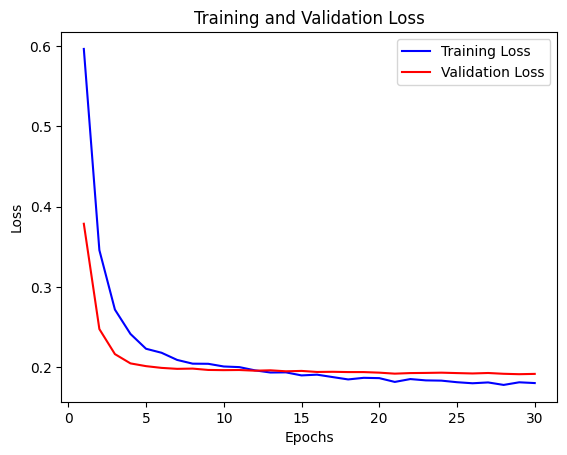

In [50]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, N_EPOCHS+1)

# Plot loss
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()